# Prepare data

In [1]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
import spacy
from tqdm import tqdm
import json

from hpsklearn import HyperoptEstimator

General notes
- Glove good
- hyperopt sus


In [2]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')

In [38]:
# glove twitter

nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])
print(X.shape)

#maybe try gensim? or stick with glove idk

(6425, 200)


In [3]:
def embed_dataset(dataset_text):
    nlp = spacy.load("spacy-twitter")
    encoded = np.array([nlp(text).vector for text in dataset_text])
    return encoded.tolist()

pheme['e_text'] = embed_dataset(pheme['text'])
twitter['e_text'] = embed_dataset(twitter['text'])
X_train = np.array([text for text in pheme['e_text']])
X_test = np.array([text for text in twitter['e_text']])
y_train  = pheme['target']
y_test = twitter['target']


In [39]:
pheme['e_text'] = X.tolist()
pheme['rank'] = pheme['followers'].rank()
pheme['group'] = np.array([int(x/(len(pheme)/5)) for x in pheme['rank']])


In [40]:
pheme_train = pheme.drop('target', axis=1)
X_tr, X_te, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.25, random_state = 42)
X_train = np.array([text for text in X_tr['e_text']])
X_test = np.array([text for text in X_te['e_text']])

In [5]:
X_test.shape

(2308, 200)

In [29]:
nlp = spacy.load("spacy-twitter")


def embed_two_datasets(set1, set2):
    nlp = spacy.load("spacy-twitter")
    all_statements = np.append(set1, set2)
    all_tf = np.array([nlp(text).vector for text in all_statements])
    return all_tf[:len(set1)], all_tf[len(set1):]

X_train, X_test = embed_two_datasets(pheme['text'], twitter['text'])
y_train  = pheme['target']
y_test = twitter['target']

In [41]:
pheme.head()

,Unnamed: 0,text,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target,e_text,rank,group
0,0,break least dead injur gunman open fire offic ...,Wed Jan 07 11:06:08 +0000 2015,14,159,H_E_Samuel,Tue Oct 04 09:36:17 +0000 2011,1628,246,1901,False,False,0,[],charliehebdo-all-rnr-threads,True,"[-0.2768873870372772, 0.07383663952350616, -0....",699.0,0
1,1,franc peopl dead shoot hq satir weekli newspap...,Wed Jan 07 11:07:51 +0000 2015,38,486,euronews,Wed Mar 18 12:57:11 +0000 2009,129573,337,48440,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.14176881313323975, -0.011955440044403076, ...",3911.0,3
2,2,ten kill shoot headquart french satir weekli c...,Wed Jan 07 11:08:09 +0000 2015,15,127,Channel4News,Mon Apr 28 14:29:37 +0000 2008,529882,3051,66682,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.33279091119766235, -0.03940924257040024, -...",4806.0,3
3,3,break dead shoot headquart french satir weekli...,Wed Jan 07 11:09:50 +0000 2015,15,105,AlArabiya_Eng,Sat Feb 28 08:31:32 +0000 2009,499741,31,100466,False,True,2,[],charliehebdo-all-rnr-threads,True,"[-0.3347603678703308, -0.05270244926214218, 0....",4768.0,3
4,4,reuter peopl shot dead headquart french satir ...,Wed Jan 07 11:11:16 +0000 2015,32,412,SkyNewsBreak,Wed Nov 04 11:25:45 +0000 2009,1377384,6,27228,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.3408753275871277, 0.021153461188077927, -0...",5386.0,4


In [ ]:
def encode_two_datasets(set1, set2):
    tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
    all_statements = np.append(set1, set2)
    all_tf = tfidf.fit_transform(all_statements)
    return all_tf[:len(set1)], all_tf[len(set1):]

In [ ]:
# DO NOT RUN THIS BLOCK UNLESS YOU WANT TO USE TFIDF ENCODING

rs = 42
method = 3
tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = CountVectorizer(max_df=0.6, min_df=0)

if method == 0:
    pheme_tf = tfidf.fit_transform(pheme['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(pheme_tf, pheme['target'], test_size = 0.25, random_state = rs)
elif method == 1:
    polit_tf = tfidf.fit_transform(politifact['statement'].values)
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    twitter_tf = tfidf.fit_transform(twitter['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_train, X_test = encode_two_datasets(twitter['text'].values, pheme['text'].values)
    y_test = pheme['target']
    y_train = twitter['verdict']
else:
    X_train, X_test = encode_two_datasets(politifact['statement'].values, pheme['text'].values)
    y_train = politifact['verdict']
    y_test = pheme['target']
    

# Set no. of folds
num_folds = 10

###Things to do: add more features
print(X_train.shape)

(1729, 6101)


# Run models

In [ ]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [ ]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [6]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50,
                            trial_timeout=120)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [7]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True, random_state=42), X_train, y_train)

100%|██████████| 50/50 [00:06<00:00,  6.87s/trial, best loss: 0.3525291828793774]
{'learner': SVC(C=0.9327005391379788, coef0=0.02234885845611312, degree=1, kernel='poly',
    probability=True, random_state=42, tol=0.00011636012749123017), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 41.46 %
F1: 41.43 %


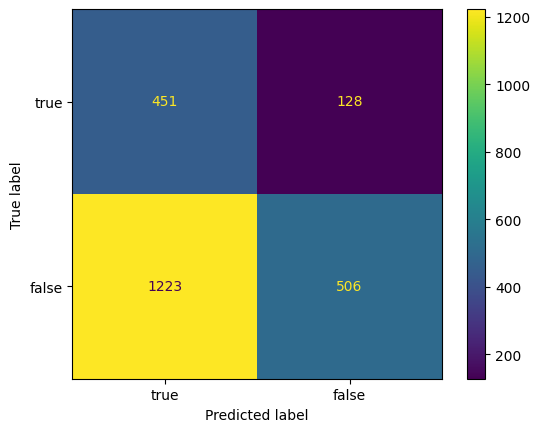

In [8]:
evaluate_model(svm, X_test, y_test)

In [9]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN"), X_train, y_train)

100%|██████████| 50/50 [00:10<00:00, 10.02s/trial, best loss: 0.3424124513618677]
{'learner': KNeighborsClassifier(leaf_size=25, metric='cityblock', n_jobs=1, n_neighbors=11,
                     p=3.382396355518109), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 46.53 %
F1: 45.95 %


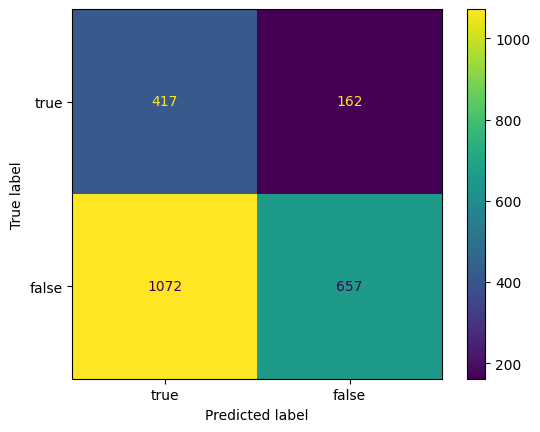

In [10]:
evaluate_model(knn, X_test, y_test)

In [12]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR", random_state=42), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.79s/trial, best loss: 0.36964980544747084]
{'learner': LogisticRegression(C=0.15039987572886282, max_iter=736, n_jobs=1,
                   random_state=42, solver='newton-cg',
                   tol=0.002299634672497379), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 41.12 %
F1: 41.09 %


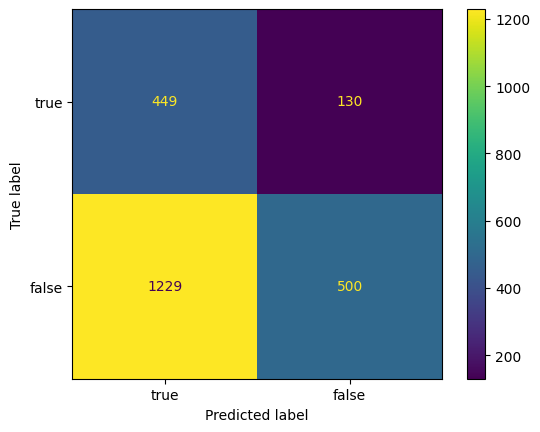

In [13]:
evaluate_model(myLR, X_test, y_test)

In [14]:
# AdaBoost
from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT, random_state=42), X_train, y_train)

100%|██████████| 50/50 [00:04<00:00,  4.39s/trial, best loss: 0.3431906614785992]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'learner': AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_features=0.23162965981097083,
                                                         random_state=2),
                   learning_rate=0.025633294778562726, n_estimators=14,
                   random_state=42), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 41.07 %
F1: 41.06 %


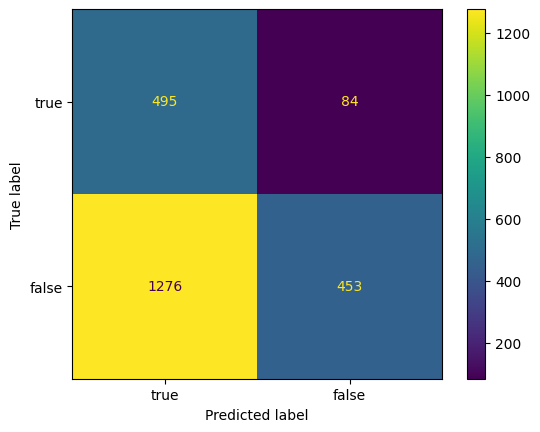

In [15]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [16]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp", random_state=42), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:03<00:00,  3.59s/trial, best loss: 0.3120622568093385]
{'learner': MLPClassifier(alpha=0.008684045355432721, beta_1=0.8379790011446323,
              beta_2=0.9517573862114284, epsilon=6.809774258095259e-06,
              learning_rate='invscaling',
              learning_rate_init=0.053539420182642905, max_fun=17077,
              max_iter=299, momentum=0.8037943309707922, n_iter_no_change=30,
              power_t=0.17794690793920642, random_state=42,
              tol=0.005095453845886264, validation_fraction=0.177351323261798), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 47.36 %
F1: 46.9 %


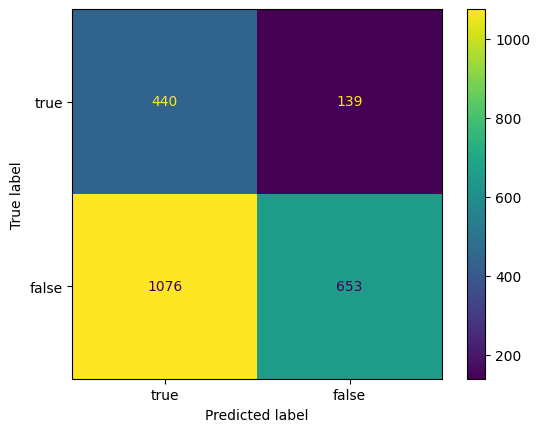

In [17]:
evaluate_model(mlp, X_test, y_test)

# Clustering

100%|██████████| 24/24 [21:30<00:00, 53.79s/it]


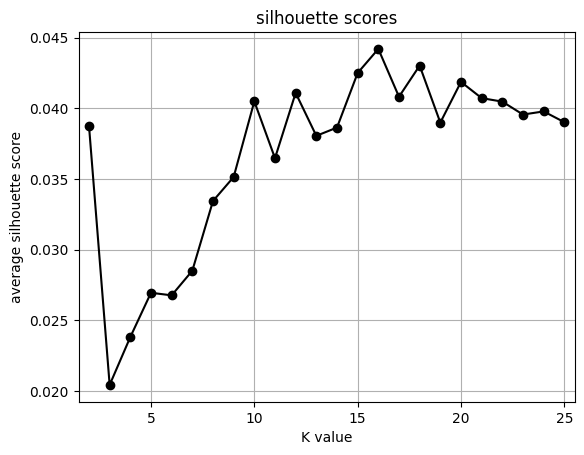

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture

n=25
n_clusters = range(2, n+1)
s_avgs = []

for k in tqdm(n_clusters):
    GM = GaussianMixture(n_components=k, n_init=10, random_state=5508)
    cluster_labels = GM.fit_predict(X_train)

    silhouette_avg = silhouette_score(X_train, cluster_labels, metric='euclidean')
    s_avgs.append(silhouette_avg)

fig, ax = plt.subplots()
ax.set_xlim([1.5, n+0.5])

ax = plt.plot(n_clusters, s_avgs, '-ok')
plt.title("silhouette scores")
plt.xlabel("K value")
plt.ylabel("average silhouette score")
plt.grid()
plt.show()

In [19]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=16)
gm_train_labels = gm.fit_predict(X_train)
gm_test_labels = gm.predict(X_test)

## Ensemble

In [20]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 43.07 %
F1: 43.04 %


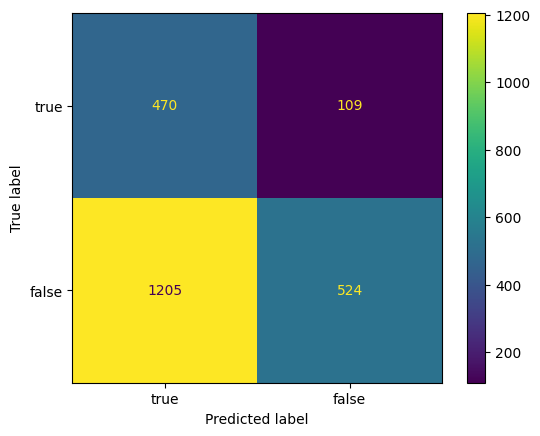

In [21]:
# Hard voting
from sklearn.ensemble import VotingClassifier


names = ["svm", "LR", "ada", "mlp", "knn"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 43.54 %
F1: 43.51 %


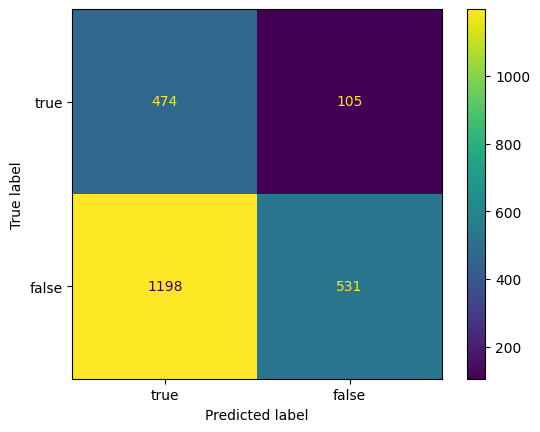

In [26]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

Accuracy: 40.73 %
F1: 40.61 %


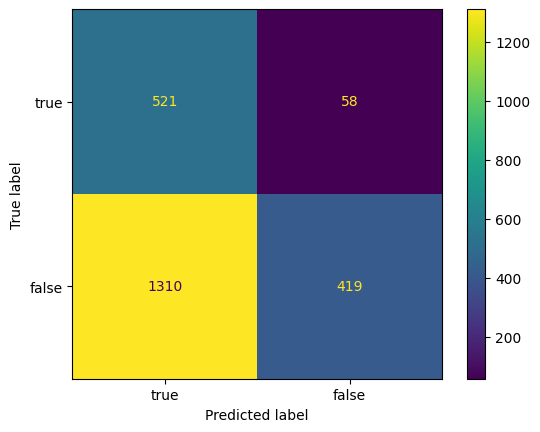

In [22]:
from deslib.des import KNORAE

e_ensemble = KNORAE(pool_classifiers=sk_classifiers)

e_ensemble.fit(X_train, y_train)
evaluate_model(e_ensemble, X_test, y_test)

Accuracy: 45.1 %
F1: 44.99 %


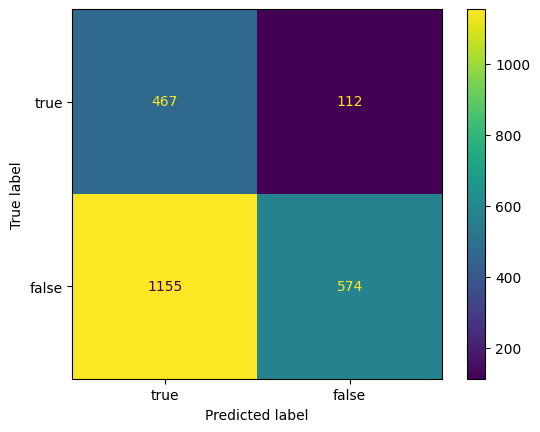

In [27]:
e_ensemble_soft = KNORAE(pool_classifiers=sk_classifiers, voting="soft")
e_ensemble_soft.fit(X_train, y_train)
evaluate_model(e_ensemble_soft, X_test, y_test)

Accuracy: 43.24 %
F1: 43.21 %


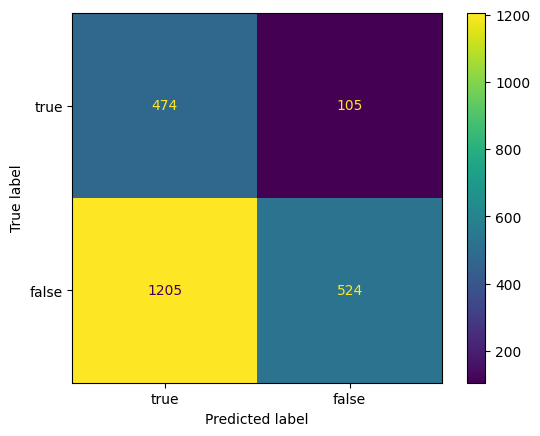

In [28]:
from deslib.des import KNORAU

u_ensemble_hard = KNORAU(pool_classifiers=sk_classifiers)

u_ensemble_hard.fit(X_train, y_train)
evaluate_model(u_ensemble_hard, X_test, y_test)

Accuracy: 44.41 %
F1: 44.35 %


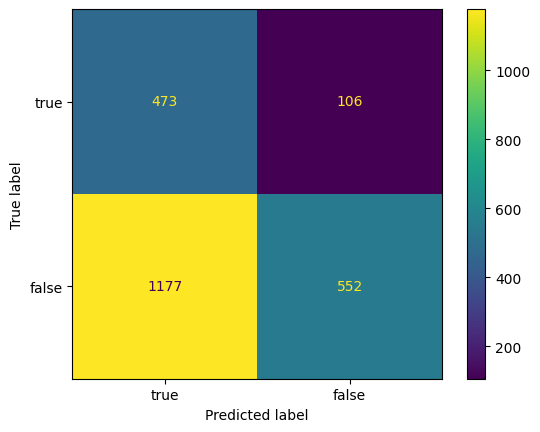

In [29]:
u_ensemble_soft = KNORAU(pool_classifiers=sk_classifiers, voting="soft")

u_ensemble_soft.fit(X_train, y_train)
evaluate_model(u_ensemble_soft, X_test, y_test)

# Custom model

In [30]:
def set_clusters(train_category_values, test_category_values):
    trained_points = {}
    for i in range(len(train_category_values)):
        if train_category_values[i] in trained_points:
            trained_points[train_category_values[i]].append(i)
        else:
            trained_points[train_category_values[i]] = [i]

    return trained_points, train_category_values, test_category_values


def predict_points(points, ensemble, train_cluster, test_cluster):
    trained_points, train_events, test_events = set_clusters(train_cluster, test_cluster)
    #print(trained_points)
    final_predictions = []
    marks = []
    for j in tqdm(range(len(points))):
        event = test_events[j]
        event_points = trained_points[event]
        model_predictions = []
        for model in ensemble:
            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))
            pred = model.predict(points[j].reshape(1,-1))
            model_predictions.append((score, pred[0]))
        mark = 0
        if j == len(points) -1:
            print(model_predictions)
        for score, pred in model_predictions:    
            if pred == True:
                mark += score
            else:
                mark -= score
        #print(mark)
        if (mark > 0):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        marks.append(model_predictions)
    return final_predictions, marks
                   

In [31]:
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    print("Accuracy:", float("{0:.2f}".format(acc*100)), "%")
    f1 = f1_score(test, pred, average="macro")
    print("F1:", float("{0:.2f}".format(f1*100)), "%")
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [137]:
o, t, s = set_clusters(gm_train_labels, gm_test_labels)
print(o.keys())
for key in o:
    print(key, len(o[key]))

dict_keys([17, 13, 3, 2, 6, 18, 9, 15, 23, 12, 16, 10, 20, 1, 21, 5, 19, 14, 22, 8, 7, 11, 4, 0])
17 79
13 118
3 149
2 119
6 137
18 42
9 78
15 120
23 18
12 18
16 86
10 87
20 117
1 147
21 90
5 47
19 53
14 78
22 28
8 26
7 40
11 93
4 30
0 1


In [64]:
def check_score_manual(a, b, marks):
    num = 0
    den = 0
    data = zip(a,b)
    data = tuple(data)
    mark = []
    for i in range(len(data)):
        if data[i][0] == data[i][1]:
            num += 1
            den += 1
        else:
            den += 1
            mark.append((marks[i], i))
    return num/den, mark

gm clusters


100%|██████████| 2308/2308 [14:23<00:00,  2.67it/s]

[(0.8517179023508138, False), (0.8553345388788427, False), (0.9981916817359855, False), (0.9837251356238698, False), (0.8878842676311031, False)]
Accuracy: 43.07 %
F1: 43.04 %


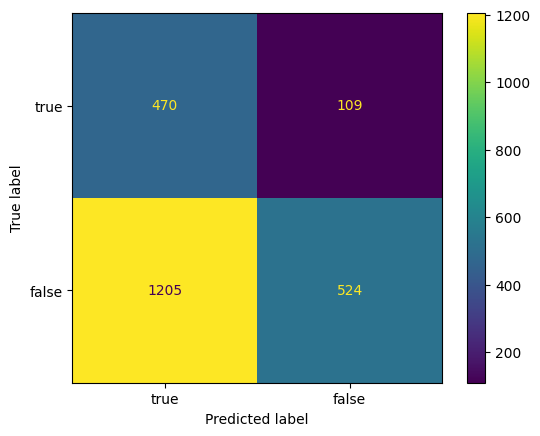

In [32]:
"""print("events")
pred1, marks1 = predict_points(X_test, sk_classifiers, X_tr['event'].values, X_te['event'].values)
check_score(y_test, pred1)
print("verified")
pred2, marks2 = predict_points(X_test, sk_classifiers, X_tr['verified'].values, X_te['verified'].values)
check_score(y_test, pred2)"""
print("gm clusters")
pred3, marks3 = predict_points(X_test, sk_classifiers, gm_train_labels, gm_test_labels)
check_score(y_test, pred3)

In [247]:
print("followers")
pheme['rank'] = pheme['followers'].rank()
pheme['group'] = np.array([int(x/(len(pheme)/5)) for x in pheme['rank']])
pred4, marks4 = predict_points(X_test, sk_classifiers, X_tr['group'].values, X_te['group'].values)
d, dmarks = check_score_manual(y_test, pred4)

followers
{4: [0, 1, 2, 8, 13, 26, 29, 30, 39, 41, 42, 45, 50, 55, 60, 66, 67, 70, 71, 79, 81, 84, 86, 87, 91, 95, 106, 115, 123, 124, 147, 152, 154, 155, 160, 172, 173, 180, 185, 194, 205, 208, 214, 215, 216, 219, 232, 239, 242, 244, 245, 256, 257, 270, 273, 283, 286, 287, 293, 306, 318, 325, 326, 328, 330, 348, 366, 372, 376, 377, 388, 389, 394, 410, 414, 417, 418, 424, 426, 433, 435, 438, 441, 444, 445, 447, 449, 451, 452, 464, 467, 471, 477, 497, 508, 525, 526, 539, 546, 548, 562, 573, 574, 582, 585, 586, 590, 595, 600, 603, 604, 611, 615, 627, 629, 630, 638, 640, 648, 656, 658, 666, 668, 673, 685, 693, 701, 704, 705, 706, 713, 715, 720, 722, 726, 729, 737, 738, 740, 743, 758, 759, 761, 768, 772, 782, 784, 788, 794, 801, 802, 806, 809, 813, 823, 834, 838, 839, 840, 841, 852, 855, 858, 875, 876, 878, 880, 881, 883, 889, 891, 892, 902, 907, 921, 927, 928, 931, 939, 954, 957, 965, 967, 971, 978, 982, 985, 988, 990, 992, 996, 1007, 1010, 1013, 1016, 1019, 1020, 1023, 1024, 1026, 1041, 

100%|██████████| 601/601 [02:34<00:00,  3.88it/s]

[(0.8975069252077562, False), (0.7451523545706371, True), (1.0, False), (0.997229916897507, False), (1.0, False)]


In [200]:
a1,a2 = map(list,zip(*amarks))
b1,b2 = map(list,zip(*bmarks))
c1,c2 = map(list,zip(*cmarks))

In [251]:
d, dmarks = check_score_manual(y_test, pred4)
print(d)
d1,d2 = map(list,zip(*dmarks))

0.8286189683860233


In [253]:
np.subtract(d2,a2).shape

(103,)

false alarm on the high score - accidentally trained some on full set
event score ~83
verified score ~83
event, verified, gm, all get the same ones wrong